In [1]:
# # IMPORTS
# astronomy
from astropy.io import fits
# plotting 
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.pyplot as plt
import matplotlib as mpl
# data 
import numpy as np
# file IO
import csv
# my python files 
import match
import v2_AGN_DataAndPlotting as adp

# Read Data

In [2]:
# open COSMOS 2020 catalog file and get data 
with fits.open(adp.path_cat+'\\COSMOS2020_CLASSIC_R1_v2.0_master.fits') as hdul20:
    data20 = hdul20[1].data
    cols20 = hdul20[1].columns

In [3]:
# get IRAC data (unit = 'uJy')
ch1_data20  = np.array(data20['SPLASH_CH1_FLUX']) # 3.5686 um
print('.', end='')
ch2_data20  = np.array(data20['SPLASH_CH2_FLUX']) # 4.5067 um
print('.', end='')
ch3_data20  = np.array(data20['SPLASH_CH3_FLUX']) # 5.7788 um
print('.', end='')
ch4_data20  = np.array(data20['SPLASH_CH4_FLUX']) # 7.9958 um 
print('.', end='')
# get ID
id_data20 = np.array(data20['ID_COSMOS2015'])
print('.', end='')

.....

In [4]:
# open COSMOS 2016 catalog file and get data 
with fits.open(adp.path_cat+'\\chandra_COSMOS_legacy_opt_NIR_counterparts_20160113_4d.fits') as hdul16:
    data16 = hdul16[1].data
    cols16 = hdul16[1].columns

In [5]:
# get data arrays from columns
id_data16 = np.array(data16['id_k_uv'])
print('.', end='')
L0510_data16 = np.array(data16['Lx_0510']) # x-ray luminosity in the 0.5-10 KeV band
print('.', end='')
k0510_data16 = np.array(data16['abs_corr_0510'])  # absorbtion correction coefficient in the 0.5-10 KeV band
print('.', end='')

...

In [6]:
def ReadRedshifts(file, printInfo=True) : 
    # read redshifts from file 
    zAll = np.array(adp.ReadFile(file))
    zID, zZ = zAll.T
    # get correct data type
    zID = np.array(zID, dtype=int)
    zZ  = np.array(zZ,  dtype=float)
    # apply mask to remove bad redshifts
    mask_z = (zZ >= 0) & (zZ < 99)
    zID = zID[mask_z]
    zZ  = zZ[mask_z]
    # print info
    if(printInfo):
        print('Number of redshifts:', len(zID))
    # build dict
    zdict = {
        'ID' : zID,
        'z' : zZ
    }
    # return dictionary of valid redshifts and IDs
    return(zdict)

# get redshifts less than or equal to zMax
def GetRedshifts_lessEq(zMax, zDict, printInfo=True) : 
    # get mask of 0<z<zMax
    mask_lt = (zDict['z'] > 0.0) & (zDict['z'] <= zMax)
    # make dict of z
    zDict_lt = {
        'ID' : zDict['ID'][mask_lt],
        'z'  : zDict['z'][mask_lt]
    }
    # print info
    if(printInfo):
        print('Number of redshifts <='+str(zMax)+':', len(zDict_lt['z']))
    # return dictionary of redshifts less than 
    return(zDict_lt)

# get redshifts
zDict = ReadRedshifts(file=adp.path_cat+'\COSMOS_z_matches.csv')
zDict_le = GetRedshifts_lessEq(zMax=1,zDict=zDict)

Cropped:  ['ID', 'z']
Number of redshifts: 485793
Number of redshifts <=1: 211361


In [7]:
def GetAGNduoFromFile(file, printInfo=True):
    # read AGN IDs
    agnIDs_file = adp.ReadFile(file)
    # convert agnIDs into a dictionary of numpy arrays 
    agnIDs_dict = { 
        'MIR'  : np.array(agnIDs_file[0], dtype=int), 
        'XRAY' : np.array(agnIDs_file[1], dtype=int) 
        }
    # print info
    if(printInfo) :
        print('Number of MIR AGN:\t',    len(agnIDs_dict['MIR']))
        print('Number of Xray AGN:\t',   len(agnIDs_dict['XRAY']))
    # return dict
    return(agnIDs_dict)

# get AGNs
agnIDs = GetAGNduoFromFile(adp.path_csv+'\\v2_AGNid_Xray_MIR.csv')

Cropped:  ['Row 1 = MIR selected AGN (Donley et al, 2012) with id, redshift, IRAC, and 24um (n=900). Row 2 = X-ray selected AGN (Lx > 10^43 erg/s) with id, redshift, IRAC, and 24um (n=1775). ']
Number of MIR AGN:	 900
Number of Xray AGN:	 1775


In [8]:
def GetAGNduo_withZ(agnIdDict, zDict, printInfo=True) : 
    # match IDs between AGN and available redshifts
    key_agnID_MIR,  key_z = match.match(agnIdDict['MIR'],  zDict['ID'])
    key_agnID_XRAY, key_z = match.match(agnIdDict['XRAY'], zDict['ID'])
    # create dict of AGN with redshfts
    agnIDs_dict_z = {
        'MIR'  : agnIdDict['MIR'][key_agnID_MIR],
        'XRAY' : agnIdDict['XRAY'][key_agnID_XRAY]
    }
    # create dict of AGN withhout redshifts
    noMIRz = np.ones(agnIdDict['MIR'].size, dtype=bool)
    noXrayz = np.ones(agnIdDict['XRAY'].size, dtype=bool)
    noMIRz[key_agnID_MIR] = False   # set match to False
    noXrayz[key_agnID_XRAY] = False
    agnIDs_dict_zNO = {
        'MIR'  : agnIdDict['MIR'][noMIRz],
        'XRAY' : agnIdDict['XRAY'][noXrayz]
    }
    # print info
    if(printInfo) :
        print('Number of MIR AGN with z:\t',    len(agnIDs_dict_z['MIR']) )
        print('Number of Xray AGN with z:\t',   len(agnIDs_dict_z['XRAY']))
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        print('Number of MIR AGN without z:\t',    len(agnIDs_dict_zNO['MIR']) )
        print('Number of Xray AGN without z:\t',   len(agnIDs_dict_zNO['XRAY']))
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        print('Total MIR AGN:\t',    len(agnIDs_dict_z['MIR']) +len(agnIDs_dict_zNO['MIR']) )
        print('Total XRAY AGN:\t',   len(agnIDs_dict_z['XRAY'])+len(agnIDs_dict_zNO['XRAY']))
    # return dict 
    return(agnIDs_dict_z, agnIDs_dict_zNO)

# get AGN with z<=1 and z>1
agnIDs_le, agnIDs_leNO = GetAGNduo_withZ(agnIDs, zDict_le)

Number of MIR AGN with z:	 139
Number of Xray AGN with z:	 381
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Number of MIR AGN without z:	 761
Number of Xray AGN without z:	 1394
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Total MIR AGN:	 900
Total XRAY AGN:	 1775


# Split MIR/X-ray into tricolor

In [9]:
def TwoToTri(irID,xrID,printInfo=True):
    # match agn ids to get overlap 
    key_ir, key_xr = match.match(irID, xrID)
    # initialize
    mask_ir = np.ones(irID.size, dtype=bool)
    mask_xr = np.ones(xrID.size, dtype=bool)
    # set matched index to false
    mask_ir[key_ir] = False
    mask_xr[key_xr] = False
    # remove overlaped xray selected agn from ir selected list
    irID_exc = irID[mask_ir]
    # remove overlaped ir selected agn from xray selected list 
    xrID_exc = xrID[mask_xr]
    # create list of ir/xray match
    ixrID_inc = irID[key_ir]
    # create and return dict of list of agn groups
    idDict = {
        'RED' : irID_exc,
        'YEL' : ixrID_inc,
        'BLU' : xrID_exc
    }
    if(printInfo):
        # print info 
        print('Number of IR only:\t',   len(idDict['RED']))
        print('Number of Xray only:\t', len(idDict['BLU']))
        print('Number of matches:\t',   len(idDict['YEL']))
    return(idDict)

# split into RED/YEl/BLU
triID = TwoToTri(agnIDs['MIR'], agnIDs['XRAY'])
print('~~~')
triID_le = TwoToTri(agnIDs_le['MIR'], agnIDs_le['XRAY'])
print('~~~')
triID_leNO = TwoToTri(agnIDs_leNO['MIR'], agnIDs_leNO['XRAY'])

Number of IR only:	 352
Number of Xray only:	 1227
Number of matches:	 548
~~~
Number of IR only:	 59
Number of Xray only:	 301
Number of matches:	 80
~~~
Number of IR only:	 293
Number of Xray only:	 926
Number of matches:	 468


In [10]:
# write IDs of AGN by selection method
with open(adp.path_csv+'\\v2_AGNid_tricolor.csv', mode='w', newline='') as csv_file:
    # initialize csv
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    # write to file 
    writer.writerow([
        'Row 1 = MIR exclusive AGN with id, redshift, IRAC, and 24um (n='+str(len(triID['RED']))+'). '+ 
        'Row 2 = MIR-X-ray inclusive AGN with id, redshift, IRAC, and 24um (n='+str(len(triID['YEL']))+'). '
        'Row 3 = X-ray exclusive AGN with id, redshift, IRAC, and 24um (n='+str(len(triID['BLU']))+'). '
    ])
    writer.writerow(triID['RED'])
    writer.writerow(triID['YEL'])
    writer.writerow(triID['BLU'])
    # confirm 
    print('List saved: v2_AGNid_tricolor.csv')

List saved: v2_AGNid_tricolor.csv


In [11]:
def TriToIRACcolors(
    id_tricolorDict,
    id_catalog,
    ch1,    # f_3.6um
    ch2,    # f_4.5 um
    ch3,    # f_5.6um
    ch4     # f_8.0um
):
    # match IDs to data20 
    key_id_red, key_red = match.match(id_catalog, id_tricolorDict['RED'])
    key_id_yel, key_yel = match.match(id_catalog, id_tricolorDict['YEL'])
    key_id_blu, key_blu = match.match(id_catalog, id_tricolorDict['BLU'])
    # calculate colors 
    xy_IRAC_tri = {
        'RED' : { 'x' : adp.IRACx(ch1[key_id_red], ch3[key_id_red]), 'y' : adp.IRACy(ch2[key_id_red], ch4[key_id_red])},
        'YEL' : { 'x' : adp.IRACx(ch1[key_id_yel], ch3[key_id_yel]), 'y' : adp.IRACy(ch2[key_id_yel], ch4[key_id_yel])},
        'BLU' : { 'x' : adp.IRACx(ch1[key_id_blu], ch3[key_id_blu]), 'y' : adp.IRACy(ch2[key_id_blu], ch4[key_id_blu])}
    }
    # return dictionary of IRAC colors by AGN group
    return(xy_IRAC_tri)

# calculate colors of IRAC 
xy_IRAC_tri = TriToIRACcolors(
    triID,
    id_data20,
    ch1_data20,ch2_data20,ch3_data20,ch4_data20 
)
# calculate colors of IRAC 
xy_IRAC_tri_le = TriToIRACcolors(
    triID_le,
    id_data20,
    ch1_data20,ch2_data20,ch3_data20,ch4_data20 
)
# calculate colors of IRAC 
xy_IRAC_tri_leNO = TriToIRACcolors(
    triID_leNO,
    id_data20,
    ch1_data20,ch2_data20,ch3_data20,ch4_data20 
)

In [12]:
# plot 3 types of AGN on Donley IRAC color-color plot
def PlotDonleyTricolor(
        x_xr, y_xr,             # X-ray (blue)
        x_ir, y_ir,             # infrared (red)
        x_ix, y_ix,             # overlap (yellow)
        path='',                # save
        fileName='',            # save
        saveNum=2,              # 2= nolegend, w/legend. 1=regular w/legend. 0=none
        printInfo=True          # output text
    ) :
    # standard plot style
    adp.SetStyle()

    # plot data
    plt.scatter(x_xr, y_xr, marker='s', c=adp.c_xray,     s=3, label='X-ray luminous (n='+str(len(x_xr))+')')
    plt.scatter(x_ir, y_ir, marker='^', c=adp.c_ir,       s=3, label='Donley selected (n='+str(len(x_ir))+')')
    plt.scatter(x_ix, y_ix, marker='o', c=adp.c_ir_xray,  s=3, label='Donley & X-ray (n='+str(len(x_ix))+')')

    # plotting class
    adp.PlotDonleyWedge()
    adp.AddText_n(len(x_ir)+len(x_xr)+len(x_ix), pre='$\mathrm{N_{total}}$ = ')

    # make plot square
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.set_adjustable('box') 

    # save
    if(path and fileName) :
        if(saveNum==2) : 
            plt.axis([-0.7,1.0,-0.7,1.0]) 
            adp.Save(path+'\\'+fileName+'.png')
        if(saveNum>=1) :
            plt.axis([-0.7,1.0,-0.7,1.0]) 
            plt.legend(loc='upper left', markerscale=2)
            adp.Save(path+'\\'+fileName+'_legend.png')
    else :
        plt.axis([-0.7,1.0,-0.7,1.0]) 
        plt.legend(loc='upper left', markerscale=2) 

    # display
    plt.show()

    # print info 
    if(printInfo) :
        print( len(x_xr) / (len(x_xr)+len(x_ix)) * 100., '% of Xray-selected sources fall outside wedge or are not monotomically rising.')
        print( len(x_ir) / (len(x_ir)+len(x_ix)) * 100. ,'% of MIR-selected sources have no Xray greater than 10^43')

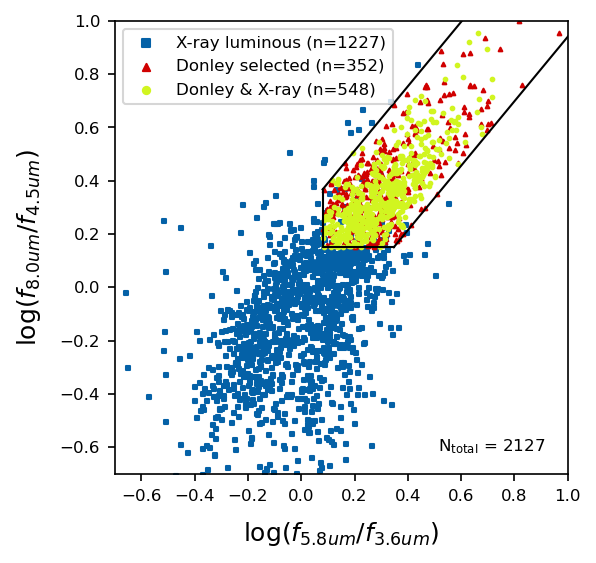

69.12676056338029 % of Xray-selected sources fall outside wedge or are not monotomically rising.
39.111111111111114 % of MIR-selected sources have no Xray greater than 10^43


In [13]:
PlotDonleyTricolor(
    xy_IRAC_tri['BLU']['x'], xy_IRAC_tri['BLU']['y'], 
    xy_IRAC_tri['RED']['x'], xy_IRAC_tri['RED']['y'], 
    xy_IRAC_tri['YEL']['x'], xy_IRAC_tri['YEL']['y'], 
    path=adp.path_fig, 
    fileName='v2_colorDiagram_tri_zAll',
    saveNum=2,
    printInfo=True
)

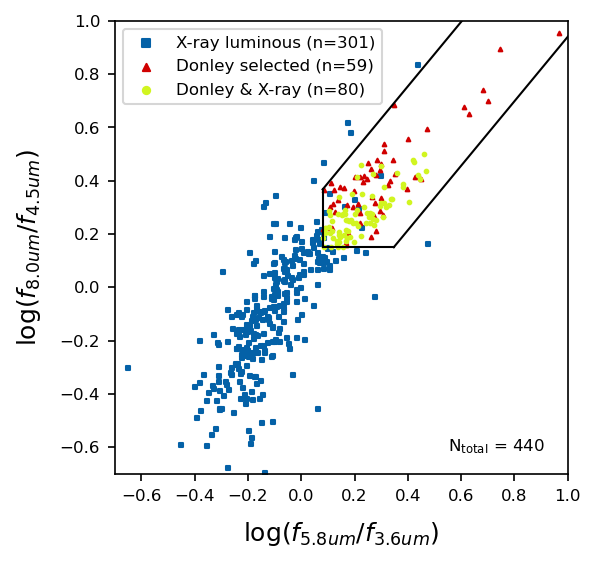

79.00262467191601 % of Xray-selected sources fall outside wedge or are not monotomically rising.
42.44604316546763 % of MIR-selected sources have no Xray greater than 10^43


In [14]:
PlotDonleyTricolor(
    xy_IRAC_tri_le['BLU']['x'], xy_IRAC_tri_le['BLU']['y'], 
    xy_IRAC_tri_le['RED']['x'], xy_IRAC_tri_le['RED']['y'], 
    xy_IRAC_tri_le['YEL']['x'], xy_IRAC_tri_le['YEL']['y'], 
    path=adp.path_fig, 
    fileName='v2_colorDiagram_tri_z01',
    saveNum=2,              
    printInfo=True          
)

In [15]:
# PlotDonleyTricolor(
#     xy_IRAC_tri_leNO['BLU']['x'], xy_IRAC_tri_leNO['BLU']['y'], 
#     xy_IRAC_tri_leNO['RED']['x'], xy_IRAC_tri_leNO['RED']['y'], 
#     xy_IRAC_tri_leNO['YEL']['x'], xy_IRAC_tri_leNO['YEL']['y']#, 
#     # path='', fileName='',   # save
#     # saveNum=2,              # 3=full,zoom,zoom w/legend. 2= zoom,zoom w/legend. 1=zoom w/legend. 0=none
#     # printInfo=True          # output text
# )

In [16]:
# plot 3 types of AGN on Donley IRAC color-color plot
def PlotDonleyTricolor_Dual(    
    x_xr_z, y_xr_z,         # X-ray (blue) with z
    x_ir_z, y_ir_z,         # infrared (red) with z
    x_ix_z, y_ix_z,         # overlap (yellow) with z
    x_xr, y_xr,             # X-ray (blue)
    x_ir, y_ir,             # infrared (red)
    x_ix, y_ix,             # overlap (yellow)
    path='', fileName='',   # save
    printInfo=True,         # output text
    outlineColor=False      # sets edgecolor to darker color or point when true, edgecolor is black otherwise
) :

    # set to darker color
    if(outlineColor) : 
        ec_xray    = adp.darken_color(adp.c_xray   )
        ec_ir      = adp.darken_color(adp.c_ir     )
        ec_ir_xray = adp.darken_color(adp.c_ir_xray)
    else:
        # set to black 
        ec_xray    = 'k'
        ec_ir      = 'k'
        ec_ir_xray = 'k'

    # plot data
    plt.scatter(x_xr, y_xr, marker='s', c=adp.c_xray   , edgecolors='none', alpha=0.3, s=15)
    plt.scatter(x_ir, y_ir, marker='^', c=adp.c_ir     , edgecolors='none', alpha=0.3, s=15)
    plt.scatter(x_ix, y_ix, marker='o', c=adp.c_ir_xray, edgecolors='none', alpha=0.3, s=15)

    # plot z data
    plt.scatter(x_xr_z, y_xr_z, marker='s', c=adp.c_xray   ,  edgecolors=ec_xray   , linewidths=0.5, s=15)
    plt.scatter(x_ir_z, y_ir_z, marker='^', c=adp.c_ir     ,  edgecolors=ec_ir     , linewidths=0.5, s=15)
    plt.scatter(x_ix_z, y_ix_z, marker='o', c=adp.c_ir_xray,  edgecolors=ec_ir_xray, linewidths=0.5, s=15)

    # plotting class
    adp.PlotDonleyWedge(linewidth=1)
    adp.AddText_n(len(x_ir)+len(x_xr)+len(x_ix)+len(x_ir_z)+len(x_xr_z)+len(x_ix_z), pre='$\mathrm{N_{total}}$ = ')

    # axis 
    plt.axis([-0.7,1.0,-0.7,1.0])
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.set_adjustable('box')
    
    # save
    if(path and fileName) :
        adp.Save(path+'\\'+fileName+'.png')

    # print info 
    if(printInfo) :
        print('z>1')
        print('Number of red:\t',   len(x_ir))
        print('Number of blu:\t',  len(x_xr))
        print('Number of yel:\t',len(x_ix))
        print('0<z<1')
        print('Number of red:\t',   len(x_ir_z))
        print('Number of blu:\t',  len(x_xr_z))
        print('Number of yel:\t',len(x_ix_z))
        print('All z')
        print('Number of red:\t',   len(x_ir)+len(x_ir_z))
        print('Number of blu:\t',  len(x_xr)+len(x_xr_z))
        print('Number of yel:\t',len(x_ix)+len(x_ix_z))

    # display
    plt.show()


z>1
Number of red:	 293
Number of blu:	 926
Number of yel:	 468
0<z<1
Number of red:	 59
Number of blu:	 301
Number of yel:	 80
All z
Number of red:	 352
Number of blu:	 1227
Number of yel:	 548


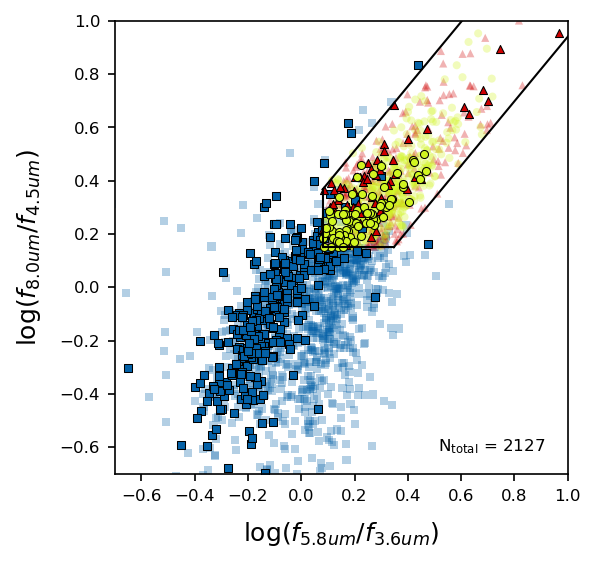

In [29]:
PlotDonleyTricolor_Dual(
    xy_IRAC_tri_le['BLU']['x'], xy_IRAC_tri_le['BLU']['y'], 
    xy_IRAC_tri_le['RED']['x'], xy_IRAC_tri_le['RED']['y'], 
    xy_IRAC_tri_le['YEL']['x'], xy_IRAC_tri_le['YEL']['y'],
    
    xy_IRAC_tri_leNO['BLU']['x'], xy_IRAC_tri_leNO['BLU']['y'], 
    xy_IRAC_tri_leNO['RED']['x'], xy_IRAC_tri_leNO['RED']['y'], 
    xy_IRAC_tri_leNO['YEL']['x'], xy_IRAC_tri_leNO['YEL']['y'],

    path=adp.path_fig, 
    fileName='v2_colorDiagram_tri_zMarked',   # save
    printInfo=True,         # output text
    outlineColor=False      # sets edgecolor to darker color or point when true, edgecolor is black otherwise
)

# X-ray data for color diagram

In [18]:
def GetXrayFromAGNDuo(
    agnIDs_dict,
    id_data16,
    L0510_data16,
    k0510_data16,
    printInfo=True
):
    # merge AGN lists into one
    agnIDs_full = np.unique(np.concatenate((agnIDs_dict['MIR'],agnIDs_dict['XRAY'])))
    
    ### get AGN with a good Lx 

    # get key to the IDs from C-COSMOS data, which are parallel to Xray data
    key_agnID, key_id = match.match(agnIDs_full, id_data16)

    # get xray luminosity data
    Lx_agn = adp.IntrinsicLuminosity(L0510_data16[key_id], k0510_data16[key_id])
    mask_Lx_agn_good = Lx_agn > 0     

    # make dict containing ID and Lx
    agnLx_dict = {
        'ID' : agnIDs_full[(key_agnID[mask_Lx_agn_good])], # key_agnID and key_id are the same size and order
        'Lx' : Lx_agn[mask_Lx_agn_good]
    }

    ### get remaining AGN 

    # match all agn to those with Lx
    key_fullLx, key_Lx = match.match(agnIDs_full, agnLx_dict['ID'])

    # get AGN without Lx
    mask_noLx = np.ones(agnIDs_full.shape, dtype=bool)
    mask_noLx[key_fullLx] = False 
    agn_noLx = { 'ID' : agnIDs_full[mask_noLx] }

    # print info 
    if(printInfo):
        print('Number of AGN with Lx detection:\t', len(agnLx_dict['ID']))
        print('Number of AGN without Lx detection:\t', len(agn_noLx['ID']))
        print('Number of all AGN :\t\t\t', len(agnLx_dict['ID'])+len(agn_noLx['ID']))

    # return agn with and without Lx
    return(agnLx_dict, agn_noLx)

# get AGN with Luminosity
agn_yLx, agn_nLx =  GetXrayFromAGNDuo(
    agnIDs,
    id_data16,
    L0510_data16,
    k0510_data16
)
print('~~~')
agn_yLx_le, agn_nLx_le =  GetXrayFromAGNDuo(
    agnIDs_le,
    id_data16,
    L0510_data16,
    k0510_data16
)
print('~~~')
agn_yLx_leNO, agn_nLx_leNO =  GetXrayFromAGNDuo(
    agnIDs_leNO,
    id_data16,
    L0510_data16,
    k0510_data16
)

Number of AGN with Lx detection:	 1795
Number of AGN without Lx detection:	 332
Number of all AGN :			 2127
~~~
Number of AGN with Lx detection:	 401
Number of AGN without Lx detection:	 39
Number of all AGN :			 440
~~~
Number of AGN with Lx detection:	 1394
Number of AGN without Lx detection:	 293
Number of all AGN :			 1687


In [19]:
def IDtoIRACcolors(
    id_agn,
    id_catalog,
    ch1,    # f_3.6um
    ch2,    # f_4.5 um
    ch3,    # f_5.6um
    ch4     # f_8.0um
):
    # match IDs to get IRAC channels 
    key_cat, key_agn = match.match(id_catalog, id_agn)
    # calculate colors
    xy = {
        'x' : adp.IRACx(ch1[key_cat], ch3[key_cat]),
        'y' : adp.IRACy(ch2[key_cat], ch4[key_cat])
    }
    return(xy)

# get colors 
xy_agn_yLx = IDtoIRACcolors(
    agn_yLx['ID'],
    id_data20,ch1_data20,ch2_data20,ch3_data20,ch4_data20 
)
xy_agn_nLx = IDtoIRACcolors(
    agn_nLx['ID'],
    id_data20,ch1_data20,ch2_data20,ch3_data20,ch4_data20 
)

xy_agn_yLx_le = IDtoIRACcolors(
    agn_yLx_le['ID'],
    id_data20,ch1_data20,ch2_data20,ch3_data20,ch4_data20 
)
xy_agn_nLx_le = IDtoIRACcolors(
    agn_nLx_le['ID'],
    id_data20,ch1_data20,ch2_data20,ch3_data20,ch4_data20 
)

xy_agn_yLx_leNO = IDtoIRACcolors(
    agn_yLx_leNO['ID'],
    id_data20,ch1_data20,ch2_data20,ch3_data20,ch4_data20 
)
xy_agn_nLx_leNO = IDtoIRACcolors(
    agn_nLx_leNO['ID'],
    id_data20,ch1_data20,ch2_data20,ch3_data20,ch4_data20 
)

In [20]:
# plot AGN w/ and w/o Xrays on Donley IRAC color-color plot with X-ray luminosity colorbar
def PlotDonleyXray(
        x_nX, y_nX,             # no X-ray detections 
        x_yX, y_yX,             # yes X-ray detections
        Lx,                     # X-ray luminosity (colorbar)
        path='',                # save
        fileName='',            # save
        saveNum=2,              # save different versions of plot 
        printInfo=True          # output text
    ) :
    
    # plot data16
    plt.scatter(x_nX, y_nX, marker='x', s=4, c='lightgrey', label='No X-ray (n='+str(len(x_nX))+')')
    plt.scatter(x_yX, y_yX, marker='D', s=3, c=Lx, cmap=plt.cm.get_cmap('inferno',9), label='Has X-ray (n='+str(len(x_yX))+')')

    # color bar 
    plt.clim(41.5, 46.0) # colorbar limits 
    plt.colorbar(label='$\log( \; L_{x(0.5-10keV)} \; [erg \; s^{-1}] \;)$')

    # plotting
    adp.PlotDonleyWedge()
    adp.AddText_n(len(x_nX)+len(x_yX), pre='$\mathrm{N_{total}}$ = ')

    # make plot square
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.set_adjustable('box') 

    # save
    if(path and fileName) :
        if(saveNum==2) : 
            plt.axis([-0.7,1.0,-0.7,1.0]) 
            adp.Save(path+'\\'+fileName+'.png')
        if(saveNum>=1) :
            plt.axis([-0.7,1.0,-0.7,1.0]) 
            plt.legend(loc='upper left', markerscale=2)
            adp.Save(path+'\\'+fileName+'_legend.png')
    else :
        plt.axis([-0.7,1.0,-0.7,1.0]) 
        plt.legend(loc='upper left', markerscale=2) 

    # display
    plt.show()

    #print info 
    if(printInfo) : 
        print('Number with Xray:\t',    len(x_yX))
        print('Number without Xray:\t', len(x_nX))
        print('Total Number:\t\t',      len(x_yX)+len(x_nX))
    

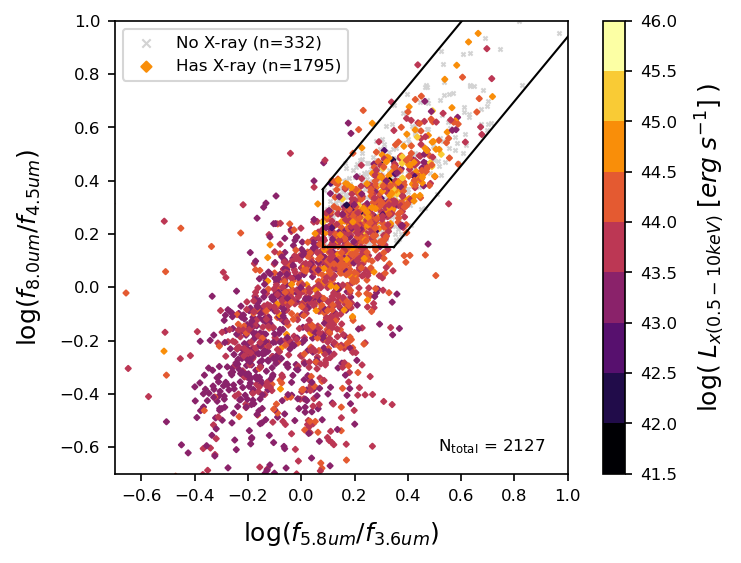

Number with Xray:	 1795
Number without Xray:	 332
Total Number:		 2127


In [21]:
PlotDonleyXray(
    xy_agn_nLx['x'], xy_agn_nLx['y'],             # no X-ray detections 
    xy_agn_yLx['x'], xy_agn_yLx['y'],             # yes X-ray detections
    agn_yLx['Lx'],                     # X-ray luminosity (colorbar)
    path=adp.path_fig, 
    fileName='v2_colorDiagram_Lx_zAll',
    saveNum=2,              # save different versions of plot 
    printInfo=True          # output text
)

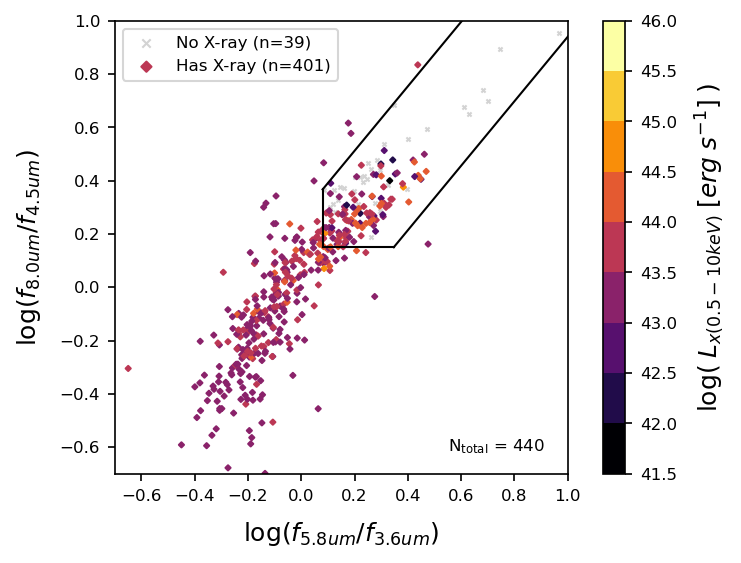

Number with Xray:	 401
Number without Xray:	 39
Total Number:		 440


In [22]:
PlotDonleyXray(
    xy_agn_nLx_le['x'], xy_agn_nLx_le['y'],             # no X-ray detections 
    xy_agn_yLx_le['x'], xy_agn_yLx_le['y'],             # yes X-ray detections
    agn_yLx_le['Lx'],                     # X-ray luminosity (colorbar)
    path=adp.path_fig, 
    fileName='v2_colorDiagram_Lx_z01',
    saveNum=2,              # save different versions of plot 
    printInfo=True          # output text
)

In [38]:
# plot AGN on Donley IRAC color-color plot with X-ray luminosity colorbar
def PlotDonleyXray_dual (
        x_nX_z, y_nX_z,         # no X-ray detections with z
        x_yX_z, y_yX_z,         # yes X-ray detections with z
        Lx_z,                   # X-ray luminosity (colorbar) with z

        x_nX, y_nX,             # no X-ray detections 
        x_yX, y_yX,             # yes X-ray detections
        Lx,                     # X-ray luminosity (colorbar)

        path='',                # save
        fileName='',            # save
        printInfo=True,         # output text
        showCrosses=True        # show gray crosses (representing *_nx) when True 
    ) :

    if(showCrosses):
        # plot no X data
        plt.scatter(x_nX,   y_nX,   marker='x', s=15, c='lightgrey')
        plt.scatter(x_nX_z, y_nX_z, marker='x', s=15, c='dimgray')

    # plot yes X data
    plt.scatter(x_yX,   y_yX,   marker='D', s=15, c=Lx,   edgecolor='none', alpha=0.3, cmap=plt.cm.get_cmap('inferno',9))
    plt.scatter(x_yX_z, y_yX_z, marker='D', s=15, c=Lx_z, edgecolor='k', linewidths=0.5, cmap=plt.cm.get_cmap('inferno',9))

    # color bar 
    plt.clim(41.5, 46.0) # colorbar limits 
    plt.colorbar(label='$\log( \; L_{x(0.5-10keV)} \; [erg \; s^{-1}] \;)$')

    # plotting
    adp.PlotDonleyWedge()

    # number of sources on plot
    if(showCrosses):
        adp.AddText_n(len(x_nX)+len(x_yX)+len(x_nX_z)+len(x_yX_z), pre='$\mathrm{N_{total}}$ = ')
    else:
        adp.AddText_n(len(x_yX)+len(x_yX_z), pre='$\mathrm{N_{total}}$ = ')

    # axis
    plt.axis([-0.7,1.0,-0.7,1.0]) 
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.set_adjustable('box')
    
    # save
    if(path and fileName) :
        adp.Save(path+'\\'+fileName+'.png')
    
    # print info 
    if(printInfo) :
        print('z>1')
        print('Number nX:\t',  len(x_nX))
        print('Number yX:\t',  len(x_yX))
        print('0<z<1')
        print('Number nX:\t',  len(x_nX_z))
        print('Number yX:\t',  len(x_yX_z))
        print('All z')
        print('Number nX:\t',  len(x_nX)+len(x_nX_z))
        print('Number yX:\t',  len(x_yX)+len(x_yX_z))

    # display
    plt.show()

z>1
Number nX:	 293
Number yX:	 1394
0<z<1
Number nX:	 39
Number yX:	 401
All z
Number nX:	 332
Number yX:	 1795


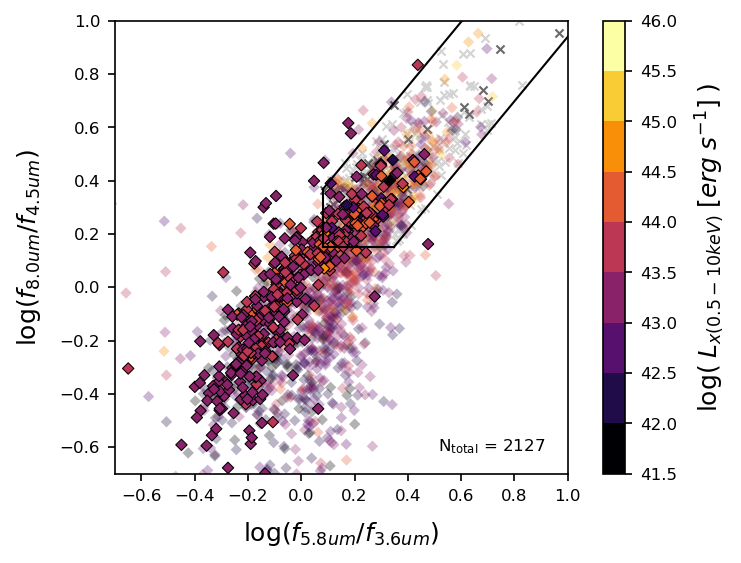

In [39]:
PlotDonleyXray_dual (
    xy_agn_nLx_le['x'], xy_agn_nLx_le['y'],             # no X-ray detections 
    xy_agn_yLx_le['x'], xy_agn_yLx_le['y'],             # yes X-ray detections
    agn_yLx_le['Lx'],                     # X-ray luminosity (colorbar)

    xy_agn_nLx_leNO['x'], xy_agn_nLx_leNO['y'],             # no X-ray detections 
    xy_agn_yLx_leNO['x'], xy_agn_yLx_leNO['y'],             # yes X-ray detections
    agn_yLx_leNO['Lx'],                     # X-ray luminosity (colorbar)

    path=adp.path_fig, 
    fileName='v2_colorDiagram_Lx_zMarked_yX',   # save
    printInfo=True,         # output text
    showCrosses=True        # show gray crosses (representing *_nx) when True 
)

z>1
Number nX:	 293
Number yX:	 1394
0<z<1
Number nX:	 39
Number yX:	 401
All z
Number nX:	 332
Number yX:	 1795


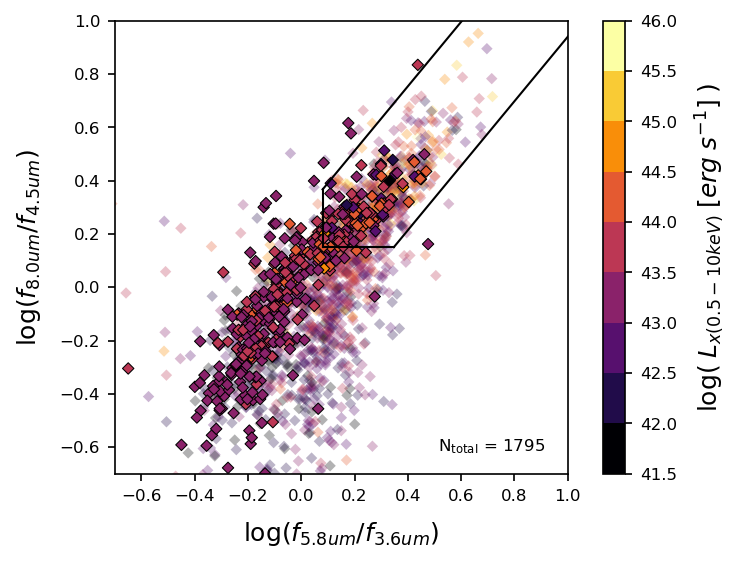

In [40]:
PlotDonleyXray_dual (
    xy_agn_nLx_le['x'], xy_agn_nLx_le['y'],             # no X-ray detections 
    xy_agn_yLx_le['x'], xy_agn_yLx_le['y'],             # yes X-ray detections
    agn_yLx_le['Lx'],                     # X-ray luminosity (colorbar)

    xy_agn_nLx_leNO['x'], xy_agn_nLx_leNO['y'],             # no X-ray detections 
    xy_agn_yLx_leNO['x'], xy_agn_yLx_leNO['y'],             # yes X-ray detections
    agn_yLx_leNO['Lx'],                     # X-ray luminosity (colorbar)

    path=adp.path_fig, 
    fileName='v2_colorDiagram_Lx_zMarked_nX',   # save
    printInfo=True,         # output text
    showCrosses=False        # show gray crosses (representing *_nx) when True 
)

In [25]:
# TODO minor ticks on plots!!!